# Vitals and lab values SFS study

## Read data

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [2]:
dropCols = [
    'micro_specimen_id',
    'person_id',
    'seven_day_mortality',
    'fourteen_day_mortality',
    'twentyone_day_mortality',
    'twentyeight_day_mortality',
    'sixty_day_mortality',
    'ninety_day_mortality',
    'onetwenty_day_mortality',
    'Ambulatory Clinic / Center',
    'Ambulatory Surgical Center',
    'Emergency Room - Hospital',
    'Emergency Room and Inpatient Visit',
    'Inpatient Visit',
    'Observation Room',
    'AMBULATORY OBSERVATION',
    'DIRECT EMER.',
    'ELECTIVE',
    'EU OBSERVATION',
    'EW EMER.',
    'OBSERVATION ADMIT',
    'SURGICAL SAME DAY ADMISSION',
    'URGENT',
    'AMBULATORY SURGERY TRANSFER',
    'CLINIC REFERRAL',
    'EMERGENCY ROOM',
    'INFORMATION NOT AVAILABLE',
    'INTERNAL TRANSFER TO OR FROM PSYCH',
    'PACU',
    'PHYSICIAN REFERRAL',
    'PROCEDURE SITE',
    'TRANSFER FROM HOSPITAL',
    'TRANSFER FROM SKILLED NURSING FACILITY',
    'WALK-IN/SELF REFERRAL',
]

X = dataDf.drop(dropCols, axis = 1)
y_seven_day = dataDf['seven_day_mortality']

## Perform SFS

In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier

sfs1 = SFS(estimator = DecisionTreeClassifier(),
           k_features=25,
           forward=True,
           floating=True,
           scoring='accuracy',
           cv=5)

sfs1.fit(X, y_seven_day)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

SequentialFeatureSelector(estimator=DecisionTreeClassifier(), floating=True,
                          k_features=25, scoring='accuracy')

In [4]:
labels = []
cv_scores = []
for key, value in sfs1.subsets_.items():
    labels.append(key)
    cv_scores.append(value['cv_scores'])

[Text(0, 0.5, 'Model Accuracy')]

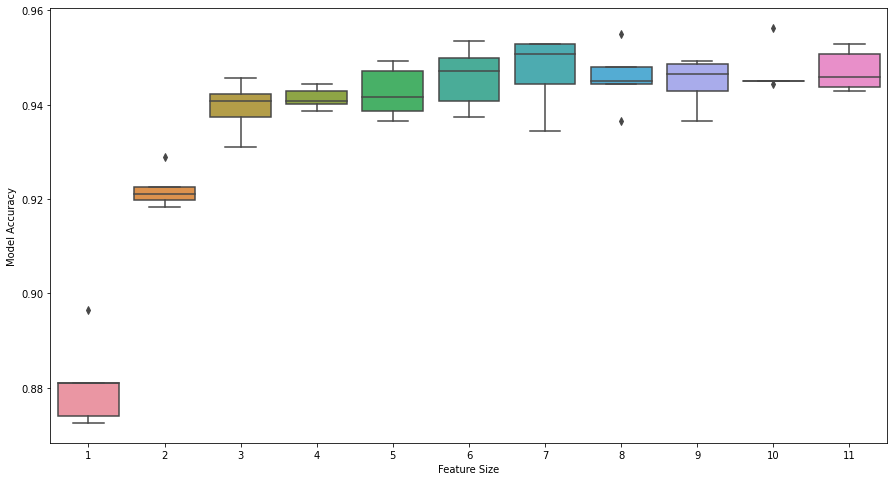

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=cv_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Accuracy')

In [3]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

sfs = SequentialFeatureSelector(estimator = DecisionTreeClassifier(), n_features_to_select=25)
sfs.fit(X, y_seven_day)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=25)

In [4]:
sfs.get_feature_names_out()

array(['visit_duration_hrs', 'heartrate_max', 'resp_rate_max',
       'oxygen_max', 'gcs_motor_max', 'gcs_verbal_max',
       'breath_rate_spon_min', 'gcs_motor_min', 'gcs_eye_min',
       'sysbp_ni_avg', 'meanbp_ni_avg', 'gcs_eye_first', 'gcs_motor_last',
       'gcs_eye_last', 'potassium_max', 'chloride_max', 'sodium_max',
       'hemoglobin_max', 'creatinine_min', 'chloride_avg',
       'hemoglobin_avg', 'creatinine_avg', 'chloride_sd',
       'chloride_first', 'sodium_first'], dtype=object)

## Obtained selected feature set

In [5]:
X_min = X[sfs.get_feature_names_out()]

In [6]:
X_min

,visit_duration_hrs,heartrate_max,resp_rate_max,oxygen_max,gcs_motor_max,gcs_verbal_max,breath_rate_spon_min,gcs_motor_min,gcs_eye_min,sysbp_ni_avg,...,chloride_max,sodium_max,hemoglobin_max,creatinine_min,chloride_avg,hemoglobin_avg,creatinine_avg,chloride_sd,chloride_first,sodium_first
0,0.269967,-1.142471,1.042698,0.391121,0.313923,-1.826353,-0.385095,-0.167166,-0.502242,-0.364828,...,-0.790523,-0.672315,-0.758013,-0.197981,-0.999905,-0.758874,0.283932,-0.023122,-1.550820,-0.833471
1,1.583718,-1.290038,0.322355,0.391121,0.313923,0.621085,-0.385095,-0.167166,-0.502242,-1.066337,...,-1.520716,-1.038764,-1.386046,0.242998,-1.558435,-1.153853,0.586553,-0.192698,-0.988574,-0.477121
2,-0.464013,0.087254,-0.037816,0.391121,0.313923,0.621085,-0.256666,0.795109,1.126579,-0.857632,...,-2.104871,-1.405213,-0.929295,-0.109785,-2.029695,-0.495555,-0.335550,-0.277739,-1.972504,-1.367996
3,-0.340886,-0.060313,-1.298416,-1.795899,0.313923,0.621085,-0.335475,0.795109,1.126579,-0.352788,...,-0.936561,-2.138111,-1.214764,-0.374373,-0.537372,-0.799385,-0.559846,-1.104911,-0.426328,-1.546171
4,1.019486,0.923466,-0.758159,0.391121,0.313923,0.107123,-0.385095,0.313972,-0.502242,-1.306151,...,1.400059,0.610257,0.897709,-0.815353,1.441920,0.476699,-0.903765,0.793514,0.417041,0.770103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,0.020127,-0.114421,0.439411,0.391121,0.313923,0.021463,-0.385095,0.313972,0.287736,-0.276302,...,0.815904,1.526379,1.297367,-0.638961,0.741762,0.971507,-0.677334,0.282418,0.557602,0.770103
7098,-0.333714,-1.290038,-1.298416,0.391121,0.313923,0.621085,-0.385095,0.795109,0.312169,0.136490,...,-0.936561,-1.038764,1.068991,1.742329,-1.008632,0.922316,1.757873,0.047799,-0.988574,-0.477121
7099,-0.432932,0.677521,-0.578073,0.391121,0.313923,0.009226,-0.364663,0.795109,1.126579,-0.221672,...,-0.352406,-1.588437,-1.728609,-0.550765,0.090975,-1.407044,-0.709376,-1.594535,0.135918,-1.011646
7100,0.483944,0.038065,-0.037816,0.391121,0.313923,0.621085,3.263453,0.313972,-1.316652,-0.506529,...,-0.206368,1.526379,-0.929295,-0.903549,-0.615915,-0.747300,-0.896289,1.018073,-0.848013,0.413753


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, X_min_train, X_min_test, y_seven_day_train, y_seven_day_test = train_test_split(X, X_min, y_seven_day, test_size=0.2, random_state=42)

In [8]:
X_train.shape, X_test.shape

((5681, 134), (1421, 134))

In [9]:
X_min_train.shape, X_min_test.shape

((5681, 25), (1421, 25))

In [10]:
y_seven_day_train.shape, y_seven_day_test.shape

((5681,), (1421,))

## Function to plot confusion matrix

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

## Function to calculate MCCF1 metric

In [77]:
import sys
import os

from sklearn.metrics import make_scorer

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# import R's "base" package
mccf1 = importr('mccf1')


def calculateMccF1(x, y):
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    p = robjects.FloatVector(x)
    t = robjects.FloatVector(y)
    calculateMccf1 = robjects.r['mccf1']
    summary = robjects.r['summary']
    out = summary(calculateMccf1(t, p), 50)[0][0]
    sys.stdout = old_stdout # reset old stdout
    return out

## XGBoost classifier

In [15]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [16]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X_train, y_seven_day_train)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

[22:31:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:31:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:31:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:31:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'max_depth': 6, 'scale_pos_weight': 0.3}

### XGBoost model with selected features

In [17]:
# xgb_min = XGBClassifier(max_depth = 12, reg_alpha = 10, max_delta_step=10, scale_pos_weight = 0.25)
xgb_min = XGBClassifier(use_label_encoder=False)
xgb_min.set_params(**params)
xgb_min.fit(X_min_train, y_seven_day_train)

xgb_min_pred = xgb_min.predict(X_min_test)
xgb_min_prob = xgb_min.predict_proba(X_min_test)

[22:32:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Confusion matrix

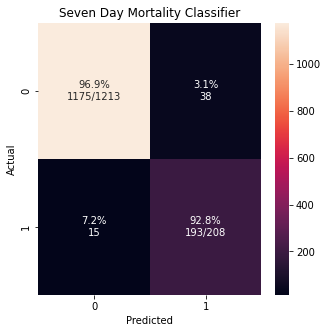

In [18]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [19]:
from sklearn.model_selection import cross_validate

xgb_min_scores = cross_validate(xgb_min, X_min_train, y_seven_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_min_scores['test_mccf1_score'] = cross_validate(xgb_min, X_min_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_min_scores

[22:32:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:32:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([0.38442826, 0.39890122, 0.4164021 , 0.39009476, 0.39610291]),
 'score_time': array([0.01605821, 0.01527286, 0.01544857, 0.01467896, 0.01513171]),
 'test_accuracy': array([0.95162709, 0.96038732, 0.96214789, 0.95158451, 0.95246479]),
 'test_balanced_accuracy': array([0.85681451, 0.88328906, 0.8917011 , 0.85925176, 0.86221034]),
 'test_average_precision': array([0.88265358, 0.93519021, 0.91516861, 0.86577726, 0.90702963]),
 'test_f1': array([0.81605351, 0.85245902, 0.86084142, 0.81727575, 0.82119205]),
 'test_roc_auc': array([0.95704558, 0.97856405, 0.96619195, 0.94798162, 0.97053046]),
 'test_mccf1_score': array([0.85157069, 0.88057632, 0.88710051, 0.85234775, 0.85544523])}

### XGBoost model with all features

In [20]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_seven_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

[22:32:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Confusion matrix

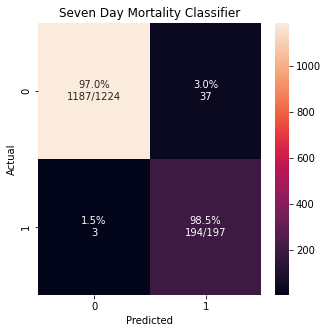

In [21]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [22]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_seven_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

[22:32:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:32:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:32:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:32:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([0.82273006, 0.69478989, 0.74407554, 0.69215894, 0.72420692]),
 'score_time': array([0.02045131, 0.02019334, 0.0199101 , 0.01981306, 0.02005839]),
 'test_accuracy': array([0.95866315, 0.96214789, 0.95774648, 0.95774648, 0.96302817]),
 'test_balanced_accuracy': array([0.8829252 , 0.88186246, 0.8669815 , 0.87019575, 0.89283026]),
 'test_average_precision': array([0.91956279, 0.9460363 , 0.93832412, 0.90556625, 0.94812005]),
 'test_f1': array([0.84789644, 0.85714286, 0.83783784, 0.84      , 0.86451613]),
 'test_roc_auc': array([0.97209521, 0.98370474, 0.97668856, 0.96677334, 0.98681948]),
 'test_mccf1_score': array([0.87663846, 0.88477996, 0.86953948, 0.87103231, 0.89014634])}

### Feature Importance

<BarContainer object of 25 artists>

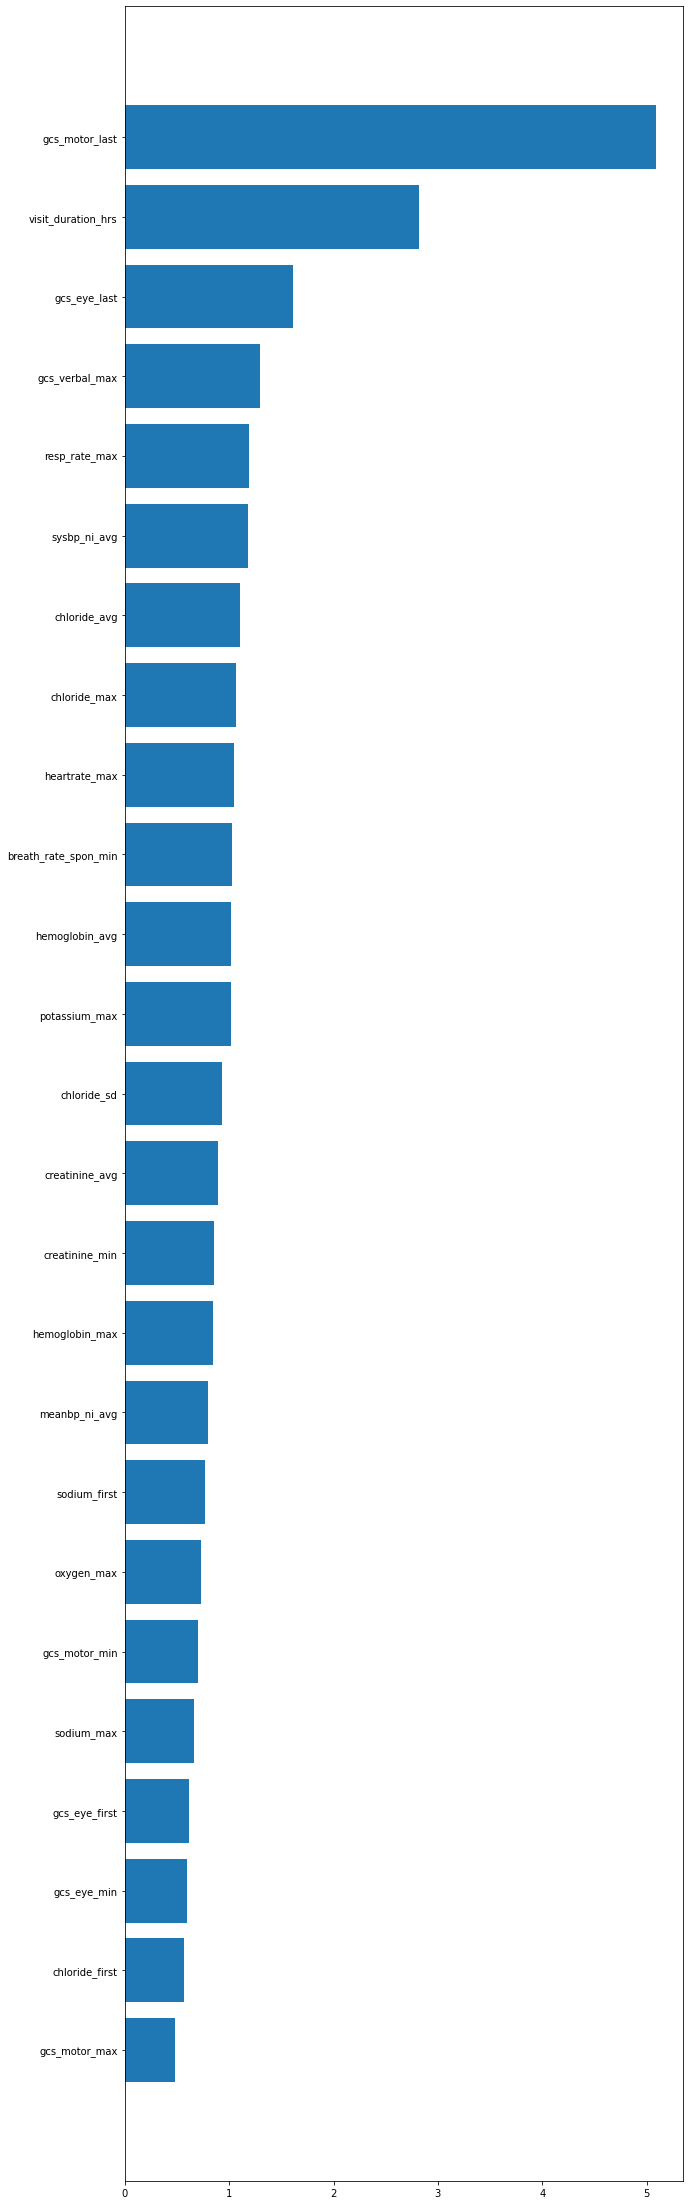

In [23]:
X_header = [x for x in X_min.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_min.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [25]:
from sklearn.model_selection import GridSearchCV

parameters={
    'solver': ['newton-cg', 'liblinear'],
    'C': [100, 10, 1.0, 0.1, 0.01],
}

clf = GridSearchCV(LogisticRegression(), parameters)
clf.fit(X_train, y_seven_day_train)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

### Logistic regression model with selected features

In [26]:
lr_min = LogisticRegression()
lr_min.set_params(**params)
lr_min.fit(X_min_train, y_seven_day_train)

lr_min_pred = lr_min.predict(X_min_test)
lr_min_prob = lr_min.predict_proba(X_min_test)

#### Confusion matrix

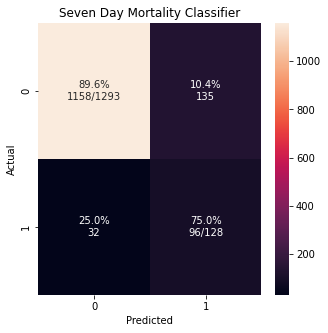

In [27]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lr_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross Validation

In [28]:
from sklearn.model_selection import cross_validate

lr_min_scores = cross_validate(lr_min, X_min_train, y_seven_day_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
lr_min_scores['test_mccf1_score'] = cross_validate(lr_min, X_min_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
lr_min_scores

 mccf1_metric best_threshold
    0.6144932              1
 mccf1_metric best_threshold
    0.6352998              1
 mccf1_metric best_threshold
    0.6441006              1
 mccf1_metric best_threshold
    0.5696831              1
 mccf1_metric best_threshold
    0.6033533              1


{'fit_time': array([0.03960896, 0.03262377, 0.03732491, 0.04377365, 0.0444541 ]),
 'score_time': array([0.00673962, 0.00616145, 0.00612903, 0.00616837, 0.00611019]),
 'test_accuracy': array([0.88654354, 0.89524648, 0.89172535, 0.88204225, 0.88732394]),
 'test_balanced_accuracy': array([0.69160472, 0.69994589, 0.7150974 , 0.65726367, 0.67989818]),
 'test_average_precision': array([0.61571239, 0.67249899, 0.65928573, 0.59128093, 0.62085311]),
 'test_f1': array([0.5204461 , 0.5440613 , 0.55913978, 0.45967742, 0.50387597]),
 'test_roc_auc': array([0.85980366, 0.88386708, 0.8710215 , 0.84333906, 0.86569822]),
 'test_mccf1_score': array([0.61449324, 0.63529983, 0.64410057, 0.56968308, 0.60335327])}

### Logistic regression model with all features

In [29]:
lr = LogisticRegression()
lr.set_params(**params)
lr.fit(X_train, y_seven_day_train)

lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)

#### Confusion matrix

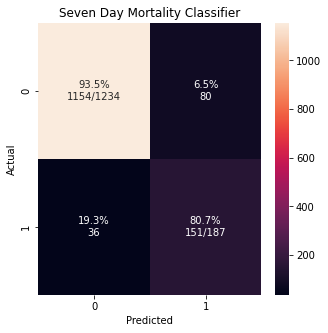

In [30]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lr_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [31]:
from sklearn.model_selection import cross_validate

lr_scores = cross_validate(lr, X_train, y_seven_day_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
lr_scores['test_mccf1_score'] = cross_validate(lr, X_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
lr_scores

 mccf1_metric best_threshold
     0.735947              1
 mccf1_metric best_threshold
    0.7807652              1
 mccf1_metric best_threshold
    0.7535602              1
 mccf1_metric best_threshold
    0.7198238              1
 mccf1_metric best_threshold
     0.751456              1


{'fit_time': array([0.42508006, 0.43726611, 0.42909622, 0.41521382, 0.40513277]),
 'score_time': array([0.00937748, 0.00936651, 0.00934696, 0.00928378, 0.00921535]),
 'test_accuracy': array([0.91292876, 0.9278169 , 0.92077465, 0.91285211, 0.92165493]),
 'test_balanced_accuracy': array([0.78768827, 0.81744392, 0.7936344 , 0.76325548, 0.78551673]),
 'test_average_precision': array([0.75541599, 0.80846058, 0.78167083, 0.74531967, 0.7705895 ]),
 'test_f1': array([0.67540984, 0.73026316, 0.69594595, 0.65263158, 0.69204152]),
 'test_roc_auc': array([0.91358991, 0.92740309, 0.91411477, 0.8964956 , 0.91162199]),
 'test_mccf1_score': array([0.73594698, 0.78076524, 0.75356018, 0.71982384, 0.751456  ])}

### Feature importance

<BarContainer object of 25 artists>

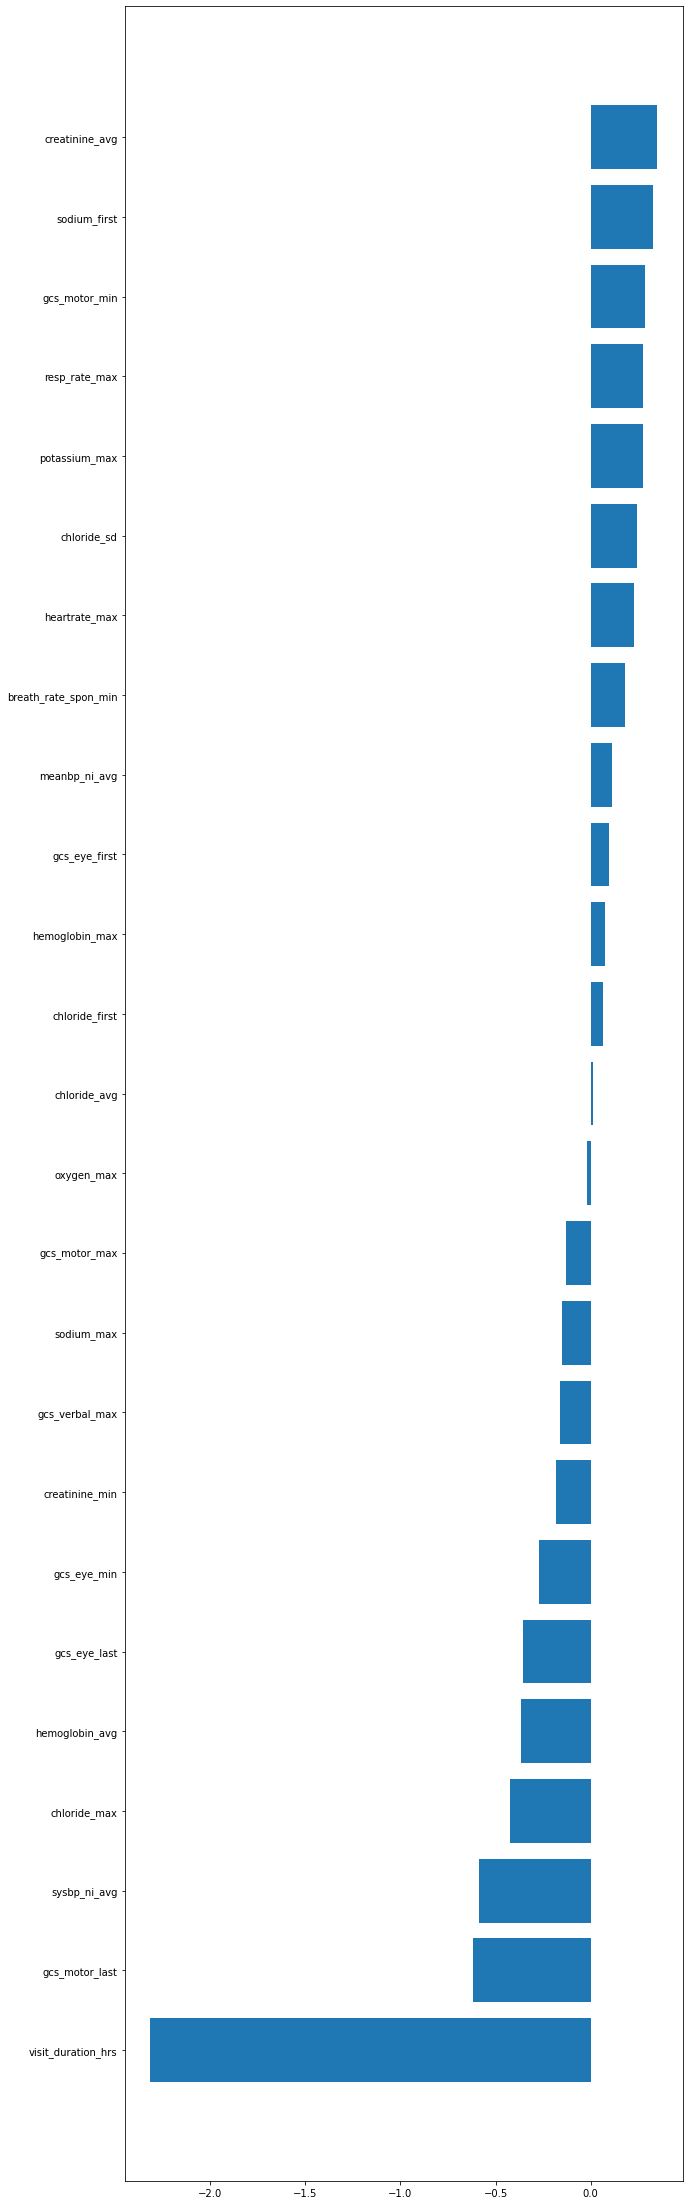

In [32]:
lrDf = pd.DataFrame(data=list(zip(X_min.columns, lr_min.coef_[0])), columns=['feature', 'weight'])
lrDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lrDf.feature, width=lrDf.weight)

## LGBM

In [33]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [34]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(LGBMClassifier(), parameters)
clf.fit(X_train, y_seven_day_train)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

### LGBM model with selected features

In [35]:
lgbm_min = LGBMClassifier()
lgbm_min.set_params(**params)
lgbm_min.fit(X_min_train, y_seven_day_train)

lgbm_min_pred = lgbm_min.predict(X_min_test)
lgbm_min_prob = lgbm_min.predict_proba(X_min_test)

#### Confusion matrix

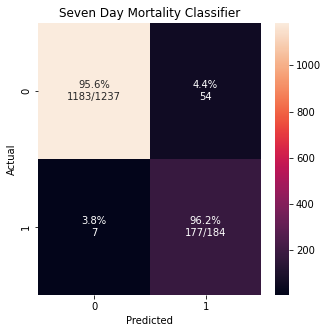

In [36]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lgbm_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [37]:
from sklearn.model_selection import cross_validate

lgbm_min_scores = cross_validate(lgbm_min, X_min_train, y_seven_day_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
lgbm_min_scores['test_mccf1_score'] = cross_validate(lgbm_min, X_min_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
lgbm_min_scores

 mccf1_metric best_threshold
    0.8013987              1
 mccf1_metric best_threshold
    0.8376547              1
 mccf1_metric best_threshold
    0.8647191              1
 mccf1_metric best_threshold
    0.8436355              1
 mccf1_metric best_threshold
    0.8365834              1


{'fit_time': array([0.21823311, 0.15140891, 0.17984653, 0.19171023, 0.15661263]),
 'score_time': array([0.00933504, 0.00907207, 0.00914955, 0.00924015, 0.00929523]),
 'test_accuracy': array([0.93843448, 0.94894366, 0.95598592, 0.94982394, 0.9471831 ]),
 'test_balanced_accuracy': array([0.80999376, 0.8372196 , 0.86594845, 0.84601005, 0.84445886]),
 'test_average_precision': array([0.88437675, 0.92679938, 0.91930984, 0.87409556, 0.90290886]),
 'test_f1': array([0.75177305, 0.7972028 , 0.83221477, 0.80546075, 0.7972973 ]),
 'test_roc_auc': array([0.95762629, 0.97667626, 0.96741563, 0.96096633, 0.97234783]),
 'test_mccf1_score': array([0.80139873, 0.83765468, 0.86471915, 0.84363546, 0.83658335])}

### Logistic regression model with selected features

In [38]:
lgbm = LGBMClassifier()
lgbm.set_params(**params)
lgbm.fit(X_train, y_seven_day_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_prob = lgbm.predict_proba(X_test)

#### Confusion matrix

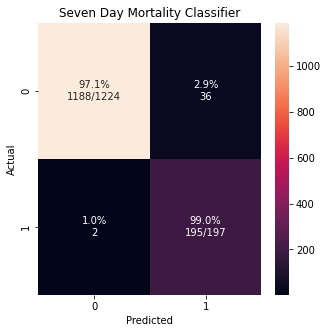

In [39]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lgbm_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [40]:
from sklearn.model_selection import cross_validate

lgbm_scores = cross_validate(lgbm, X_train, y_seven_day_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
lgbm_scores['test_mccf1_score'] = cross_validate(lgbm, X_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
lgbm_scores

 mccf1_metric best_threshold
    0.8723485              1
 mccf1_metric best_threshold
    0.8750611              1
 mccf1_metric best_threshold
    0.8866589              1
 mccf1_metric best_threshold
    0.8734385              1
 mccf1_metric best_threshold
     0.870377              1


{'fit_time': array([0.33239937, 0.32948828, 0.44694829, 0.34055161, 0.32333922]),
 'score_time': array([0.01273394, 0.01253581, 0.01245451, 0.01252007, 0.0123961 ]),
 'test_accuracy': array([0.95778364, 0.95950704, 0.96302817, 0.95862676, 0.95774648]),
 'test_balanced_accuracy': array([0.87508252, 0.87047422, 0.87991932, 0.87071281, 0.86775423]),
 'test_average_precision': array([0.91966827, 0.95052584, 0.93828711, 0.90679625, 0.94343903]),
 'test_f1': array([0.84210526, 0.84459459, 0.8590604 , 0.84280936, 0.83892617]),
 'test_roc_auc': array([0.97540222, 0.9862259 , 0.97614743, 0.9647724 , 0.98514897]),
 'test_mccf1_score': array([0.87234853, 0.87506114, 0.88665887, 0.87343847, 0.87037703])}

### Feature Importance

<BarContainer object of 25 artists>

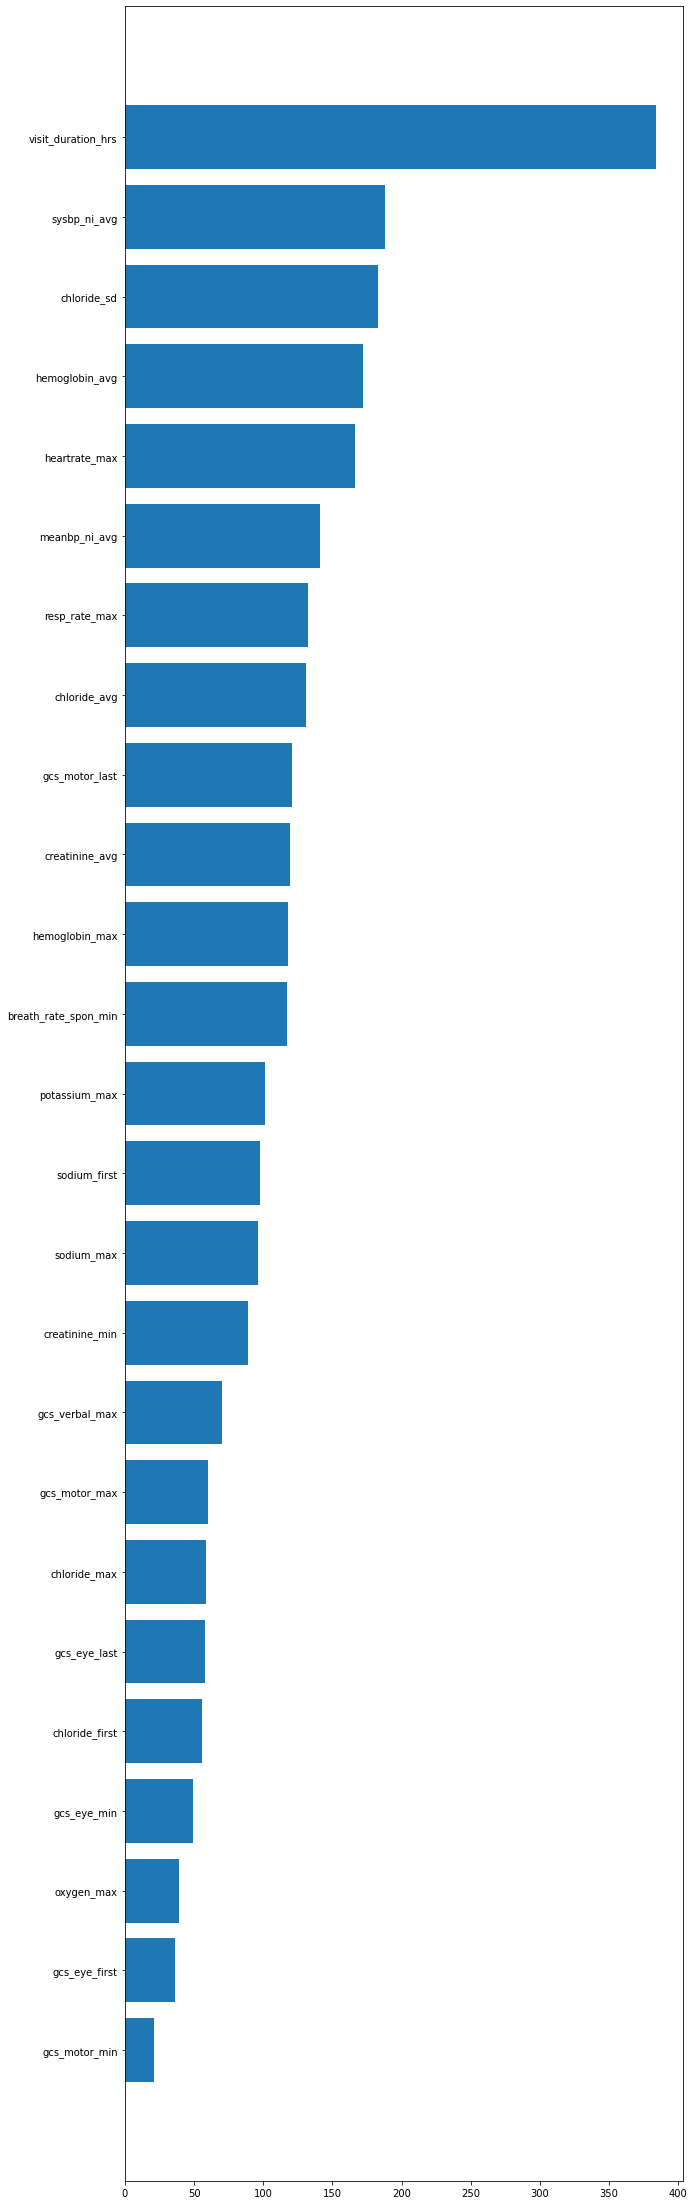

In [41]:
lgbmDf = pd.DataFrame(data=list(zip(X_min.columns, lgbm_min.feature_importances_)), columns=['feature', 'weight'])
lgbmDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=lgbmDf.feature, width=lgbmDf.weight)

### Multi Layer Perceptron

In [42]:
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt

### Multilater perceptron with selected features

In [43]:
mlp_min = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes = (50, 50))
mlp_min.fit(X_min_train, y_seven_day_train)

mlp_min_pred = mlp_min.predict(X_min_test)
mlp_min_prob = mlp_min.predict_proba(X_min_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Confusion matrix

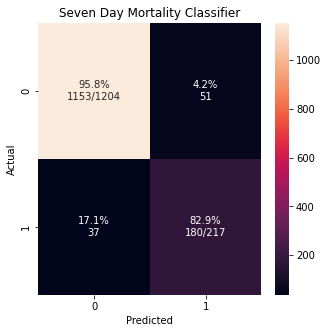

In [44]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(mlp_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [45]:
from sklearn.model_selection import cross_validate

mlp_min_scores = cross_validate(mlp_min, X_min_train, y_seven_day_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
mlp_min_scores['test_mccf1_score'] = cross_validate(mlp_min, X_min_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
mlp_min_scores

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Sto

 mccf1_metric best_threshold
    0.7972735              1


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


 mccf1_metric best_threshold
    0.8105082              1


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


 mccf1_metric best_threshold
    0.8192306              1


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


 mccf1_metric best_threshold
    0.8213097              1
 mccf1_metric best_threshold
    0.8113097              1


/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


{'fit_time': array([8.89926147, 8.97964978, 8.84075141, 8.51022339, 8.63016009]),
 'score_time': array([0.01075649, 0.010432  , 0.0103209 , 0.01057744, 0.01059127]),
 'test_accuracy': array([0.92875989, 0.93221831, 0.9375    , 0.9375    , 0.92957746]),
 'test_balanced_accuracy': array([0.84582681, 0.86184081, 0.857561  , 0.86074482, 0.87318187]),
 'test_average_precision': array([0.81031332, 0.8032746 , 0.81145448, 0.81150734, 0.8033843 ]),
 'test_f1': array([0.75229358, 0.76876877, 0.7788162 , 0.78153846, 0.77011494]),
 'test_roc_auc': array([0.9202406 , 0.93741391, 0.91553522, 0.9145102 , 0.93084205]),
 'test_mccf1_score': array([0.79727345, 0.81050816, 0.81923055, 0.82130971, 0.81130971])}

### Multilater perceptron with all features

In [46]:
mlp = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes = (200, 200))
mlp.fit(X_train, y_seven_day_train)

mlp_pred = mlp.predict(X_test)
mlp_prob = mlp.predict_proba(X_test)

#### Confusion matrix

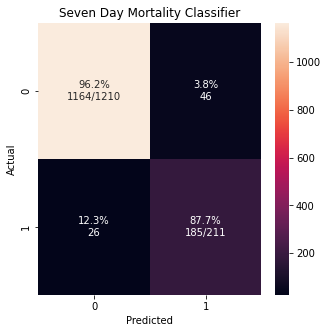

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(mlp_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [48]:
from sklearn.model_selection import cross_validate

mlp_scores = cross_validate(mlp, X_train, y_seven_day_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
mlp_scores['test_mccf1_score'] = cross_validate(mlp, X_train, y_seven_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
mlp_scores

 mccf1_metric best_threshold
    0.8405855              1
 mccf1_metric best_threshold
    0.8795439              1
 mccf1_metric best_threshold
    0.8573375              1
 mccf1_metric best_threshold
    0.8512174              1
 mccf1_metric best_threshold
    0.8557873              1


{'fit_time': array([4.54674888, 4.35567737, 4.51259089, 3.97301865, 4.2654314 ]),
 'score_time': array([0.02054358, 0.01973248, 0.0193572 , 0.01923633, 0.01976705]),
 'test_accuracy': array([0.94459103, 0.95774648, 0.94982394, 0.94894366, 0.94982394]),
 'test_balanced_accuracy': array([0.87221869, 0.90387643, 0.88938902, 0.87479119, 0.8826328 ]),
 'test_average_precision': array([0.87449167, 0.90568036, 0.88304305, 0.86233829, 0.87701762]),
 'test_f1': array([0.80495356, 0.85276074, 0.82568807, 0.81761006, 0.82352941]),
 'test_roc_auc': array([0.9519353 , 0.97389684, 0.95698667, 0.93784841, 0.95109012]),
 'test_mccf1_score': array([0.84058547, 0.87954394, 0.85733749, 0.85121738, 0.85578732])}

## AUROC

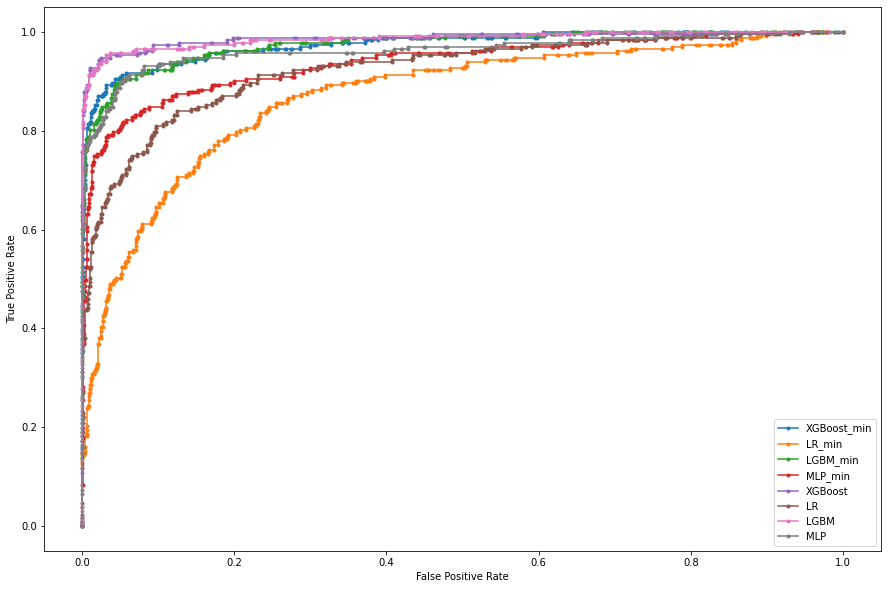

In [49]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_seven_day_test, xgb_min_prob, 'XGBoost_min')
        , (y_seven_day_test, lr_min_prob, 'LR_min')
        , (y_seven_day_test, lgbm_min_prob, 'LGBM_min')
        , (y_seven_day_test, mlp_min_prob, 'MLP_min')
        , (y_seven_day_test, xgb_prob, 'XGBoost')
        , (y_seven_day_test, lr_prob, 'LR')
        , (y_seven_day_test, lgbm_prob, 'LGBM')
        , (y_seven_day_test, mlp_prob, 'MLP')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Performance metrics

In [58]:
# labels = ['xgb', 'lr', 'lgbm', 'mlp', 'xgb_min', 'lr_min', 'lgbm_min', 'mlp_min']

scores_dict = {'xgb': (xgb_prob, xgb_pred, y_seven_day_test, xgb_scores),
               'lr': (lr_prob, lr_pred, y_seven_day_test, lr_scores),
               'lgbm': (lgbm_prob, lgbm_pred, y_seven_day_test, lgbm_scores),
               'mlp': (mlp_prob, mlp_pred, y_seven_day_test, mlp_scores),
               'xgb_min': (xgb_min_prob, xgb_min_pred, y_seven_day_test, xgb_min_scores),
               'lr_min': (lr_min_prob, lr_min_pred, y_seven_day_test, lr_min_scores),
               'lgbm_min': (lgbm_min_prob, lgbm_min_pred, y_seven_day_test, lgbm_min_scores),
               'mlp_min': (lgbm_min_prob, lgbm_min_pred, y_seven_day_test, mlp_min_scores)}

labels = []
accuracy_scores = []
balanced_accuracy_scores = []
average_precision_scores = []
f1_scores = []
roc_auc_scores = []
mccf1_scores = []

for label, (prob, pred, y, scores) in scores_dict.items():
    labels.append(label)
    for key, value in scores.items():
        if key == 'test_accuracy':
            accuracy_scores.append(value)
        if key == 'test_balanced_accuracy':
            balanced_accuracy_scores.append(value)
        if key == 'test_average_precision':
            average_precision_scores.append(value)
        if key == 'test_f1':
            f1_scores.append(value)
        if key == 'test_mccf1_score':
            mccf1_scores.append(value)
        if key == 'test_roc_auc':
            roc_auc_scores.append(value)

In [51]:
import pickle

with open('data/model_scores.p', 'wb') as fp:
    pickle.dump(scores_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Accuracy scores

[Text(0, 0.5, 'Model Accuracy')]

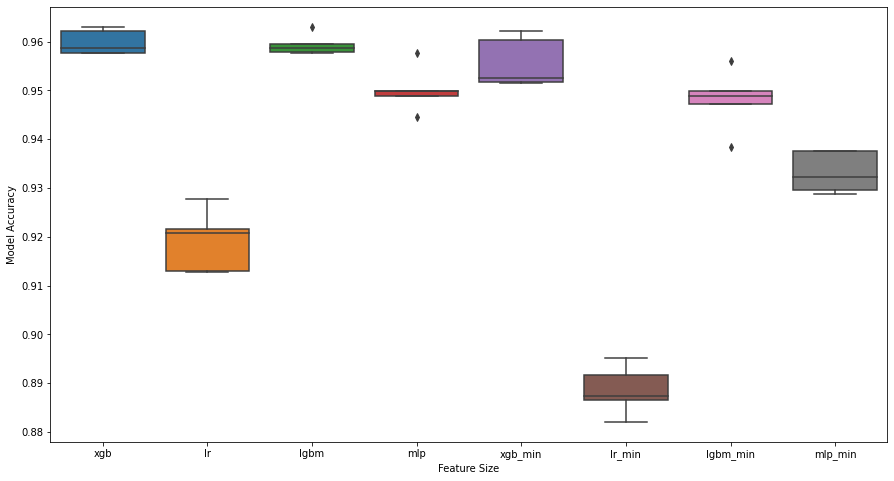

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=accuracy_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Accuracy')

### Balanced accuracy scores

[Text(0, 0.5, 'Model Balanced Accuracy')]

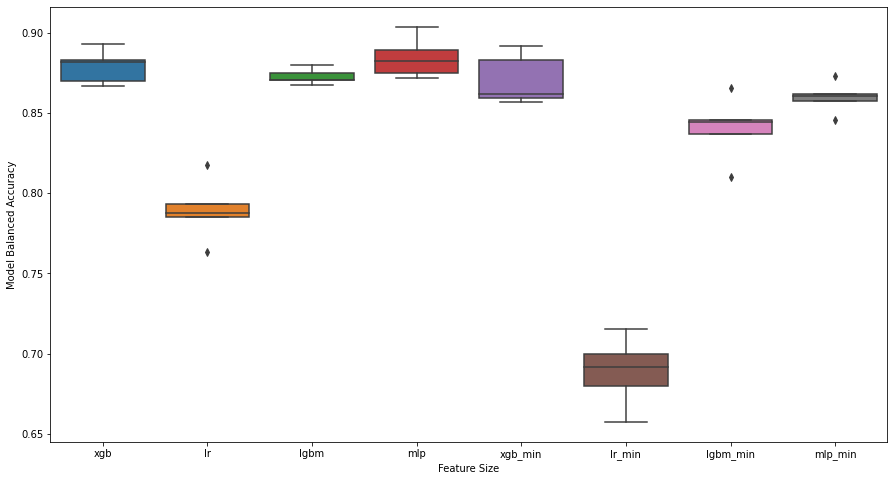

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=balanced_accuracy_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Balanced Accuracy')

### Average Precision scores

[Text(0, 0.5, 'Model Average Precision')]

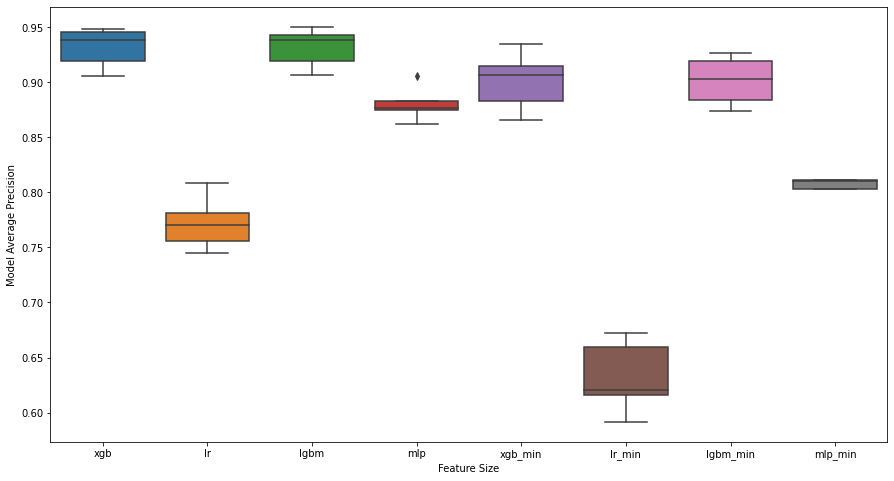

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=average_precision_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model Average Precision')

### AUROC scores

[Text(0, 0.5, 'Model AUROC')]

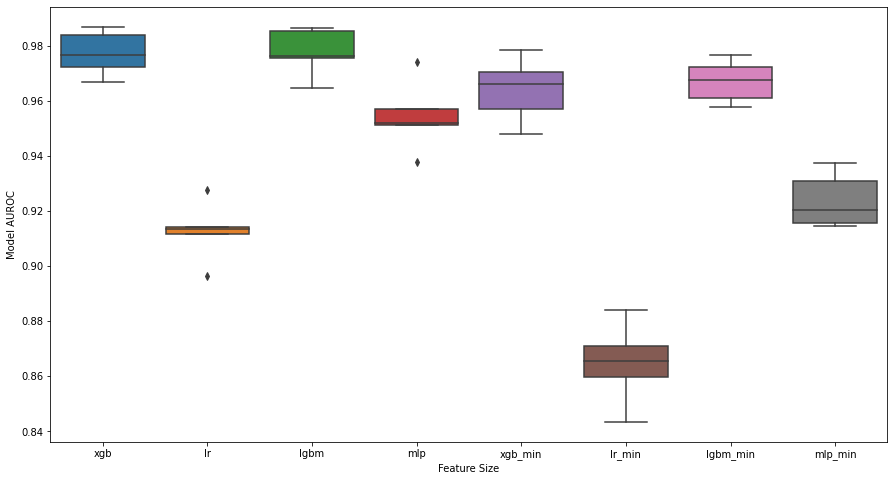

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=roc_auc_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model AUROC')

### F1 scores

[Text(0, 0.5, 'Model F1')]

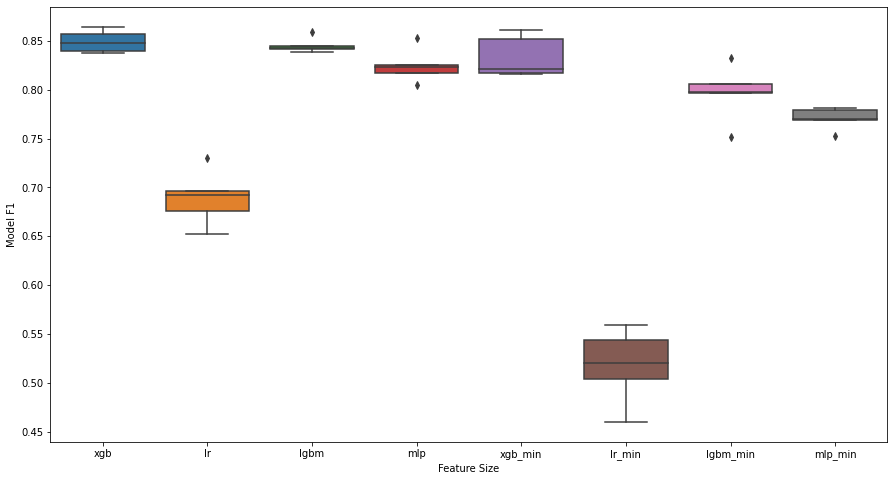

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=f1_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model F1')

### MCCF1

[Text(0, 0.5, 'Model MCCF1')]

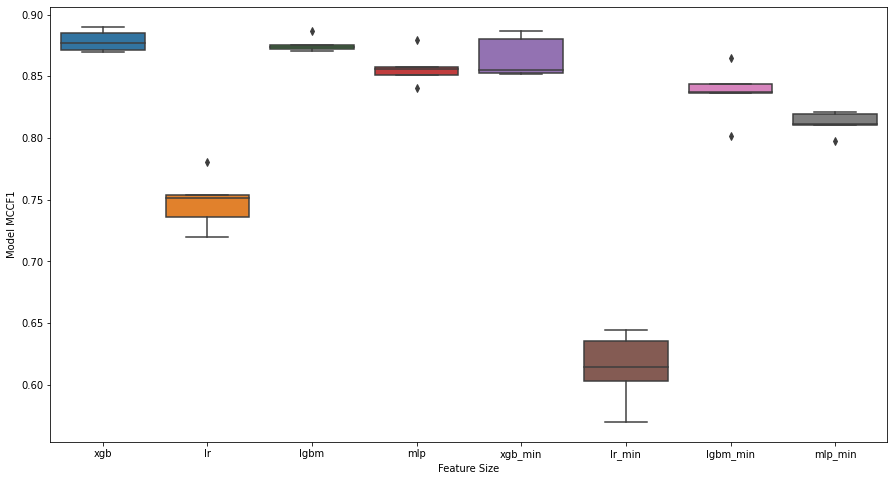

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=mccf1_scores)
ax.set(xticklabels=labels)
ax.set(xlabel='Feature Size')
ax.set(ylabel='Model MCCF1')

### Performance metrics table

In [70]:
def calculateScores(pred, y):
    return [
        accuracy_score(pred, y),
        balanced_accuracy_score(pred, y),
        average_precision_score(pred, y),
        f1_score(pred, y),
        matthews_corrcoef(pred, y),
        roc_auc_score(pred, y),
        calculateMccF1(pred, y)
    ]

In [78]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

data = []
data.append(["XGB"] + calculateScores(xgb_pred, y_seven_day_test))
data.append(["LR"] + calculateScores(lr_pred, y_seven_day_test))
data.append(["LGBM"] + calculateScores(lgbm_pred, y_seven_day_test))
data.append(["MLP"] + calculateScores(mlp_pred, y_seven_day_test))
data.append(["XGB_MIN"] + calculateScores(xgb_min_pred, y_seven_day_test))
data.append(["LR_MIN"] + calculateScores(lr_min_pred, y_seven_day_test))
data.append(["LGBM_MIN"] + calculateScores(lgbm_min_pred, y_seven_day_test))
data.append(["MLP_MIN"] + calculateScores(mlp_min_pred, y_seven_day_test))

perfromanceDf = pd.DataFrame(data, columns=["Label", "Accuracy", "Balanced Accuracy", "Average Precision", "F1", "MCC", "ROC", "MCCF1"])
perfromanceDf

,Label,Accuracy,Balanced Accuracy,Average Precision,F1,MCC,ROC,MCCF1
0,XGB,0.971851,0.977271,0.829149,0.906542,0.894005,0.977271,0.924029
1,LR,0.918367,0.871328,0.553172,0.722488,0.680436,0.871328,0.773568
2,LGBM,0.973258,0.980218,0.836993,0.911215,0.899524,0.980218,0.927866
3,MLP,0.949331,0.919380,0.720478,0.837104,0.808337,0.919380,0.866361
4,XGB_MIN,0.962702,0.948279,0.785802,0.879271,0.858936,0.948279,0.901131
5,LR_MIN,0.882477,0.822796,0.334208,0.534819,0.500937,0.822796,0.626731
6,LGBM_MIN,0.957072,0.959151,0.742010,0.853012,0.835603,0.959151,0.880916
7,MLP_MIN,0.938072,0.893567,0.672396,0.803571,0.767384,0.893567,0.838582
